In [2]:
import networkx as nx 
from matplotlib import pyplot as plt
import numpy as np
from scipy.integrate import solve_ivp
import networkx as nx
import random
import torch
import copy
from torch.distributions.bernoulli import Bernoulli
import pandas as pd

from gsnn.models.GSNN import GSNN
from gsnn.models.NN import NN
from gsnn.simulate.nx2pyg import nx2pyg
from gsnn.simulate.simulate import simulate

from gsnn.optim.Environment import Environment
from gsnn.optim.RewardScaler import RewardScaler
from gsnn.models.GSNN import GSNN
from gsnn.models import utils 

from hnet.models.HyperNet import HyperNet
from hnet.train.hnet import init_hnet

from sklearn.metrics import roc_auc_score

from gsnn.optim.REINFORCE import REINFORCE

import argparse

# for reproducibility 
torch.manual_seed(0)
np.random.seed(0)

%load_ext autoreload
%autoreload 2

# Reinforcement learning for structure optimization

In many cases, prior knowledge is incomplete, noisy or spurrious for specific prediction tasks. In this example, we will demonstrate how we can use the reinforcement learning for the optimal selection of prior knowledge. 

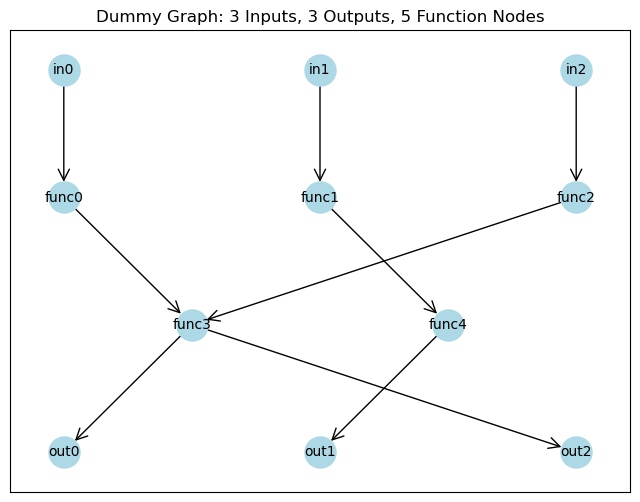

In [3]:
# Create a simple directed graph with 3 inputs, 3 outputs, and 5 function nodes
G = nx.DiGraph()

# Add input nodes, function nodes, and output nodes
input_nodes = ['in0', 'in1', 'in2']
function_nodes = ['func0', 'func1', 'func2', 'func3', 'func4']
output_nodes = ['out0', 'out1', 'out2']

# Add edges from input nodes to function nodes
G.add_edges_from([('in0', 'func0'), ('in1', 'func1'), ('in2', 'func2')])

# Add edges between function nodes
G.add_edges_from([('func0', 'func3'), ('func1', 'func4'), ('func2', 'func3')])

# Add edges from function nodes to output nodes
G.add_edges_from([('func3', 'out0'), ('func4', 'out1'), ('func3', 'out2')])

# Define positions for each node for plotting
pos = {
    'in0': (-2, 2), 'in1': (0, 2), 'in2': (2, 2),
    'func0': (-2, 1), 'func1': (0, 1), 'func2': (2, 1),
    'func3': (-1, 0), 'func4': (1, 0),
    'out0': (-2, -1), 'out1': (0, -1), 'out2': (2, -1)
}

# Plot the graph
plt.figure(figsize=(8, 6))
nx.draw_networkx(G, pos, with_labels=True, node_color='lightblue', node_size=500, font_size=10, arrowstyle='->', arrowsize=20)
plt.title("Dummy Graph: 3 Inputs, 3 Outputs, 5 Function Nodes")
plt.show()

In [4]:
#special_functions = {'func1': lambda x: -np.mean(x), 'func2':lambda x: np.sum([np.exp(xx) for xx in x]), 
#                     'func0': lambda x: np.mean(([(xx-1)**2 for xx in x])), 'func3': lambda x: -np.mean(x) if all([xx > 0 for xx in x]) else np.mean(x)}
special_functions = None

x_train, x_test, y_train, y_test = simulate(G, n_train=100, n_test=100, input_nodes=input_nodes, output_nodes=output_nodes, 
                                            special_functions=special_functions, noise_scale=0.1)

device = 'cuda' if torch.cuda.is_available() else 'cpu'
device = 'cpu'

x_train = torch.tensor(x_train, dtype=torch.float32).to(device)
x_test = torch.tensor(x_test, dtype=torch.float32).to(device)
y_train = torch.tensor(y_train, dtype=torch.float32).to(device)
y_test = torch.tensor(y_test, dtype=torch.float32).to(device)

y_mu = y_train.mean(0); y_std = y_train.std(0)

y_train = (y_train - y_mu)/(y_std + 1e-8)
y_test = (y_test - y_mu)/(y_std + 1e-8)

train_dataset = torch.utils.data.TensorDataset(x_train, y_train)
test_dataset = torch.utils.data.TensorDataset(x_test, y_test)

In [5]:
data = nx2pyg(G, input_nodes, function_nodes, output_nodes) 

# add some false edges 
edge_index_dict = copy.deepcopy(data.edge_index_dict)

#edge_index_dict['function', 'to', 'function']  = torch.cat((edge_index_dict['function', 'to', 'function'], torch.tensor([[0, 1, 1, 2],
#                                                                                                                         [1, 0, 2, 1]], dtype=torch.long)), dim=-1)

edge_index_dict['input', 'to', 'function']  = torch.cat((edge_index_dict['input', 'to', 'function'], torch.tensor([[0, 0, 1, 1],
                                                                                                                   [1, 4, 0, 2]], dtype=torch.long)), dim=-1)

In [6]:
# GSNN model parameters
model_kwargs = {'edge_index_dict'                 : edge_index_dict, 
                    'node_names_dict'                 : data.node_names_dict,
                    'channels'                        : 20, 
                    'layers'                          : 5, 
                    'dropout'                         : 0,
                    'share_layers'                    : False,
                    'add_function_self_edges'         : True,
                    'norm'                            : 'layer'}

# GSNN training parameters
training_kwargs = {'lr':1e-3, 
                    'max_epochs':20, 
                    'batch':50,
                    'workers':5}

args = argparse.Namespace()
args.outer_iters = 100

# the action edge dict will be used to index the action for each edge 
# if and edge key is not provided, those values will not be optimized (always present)
# to specify a fixed edge within a given key, use the index -1 
action_edge_dict = {('input', 'to', 'function'): torch.arange(edge_index_dict['input', 'to', 'function'].shape[1])}
n_actions = sum([torch.unique(v).numel() for v in action_edge_dict.values()])
true_action = np.array([1.]*3 + [0.]*4)

env = Environment(action_edge_dict, train_dataset, test_dataset, model_kwargs, 
                 training_kwargs, metric='spearman', reward_type='auc', verbose=False,
                 raise_error_on_fail=True)

hoptim = REINFORCE(env, n_actions, action_labels=true_action, clip=10, eps=1e-8, warmup=3, verbose=True, 
                        entropy=0., entropy_decay=0.99, min_entropy=0.0, window=10,
                        init_prob=0.5, lr=1e-1, policy_decay=0)

for iter in range(args.outer_iters): 

    hoptim.step()


			 --> iter: 2 || auroc 0.500 || acc: 0.571 || prob(true_action): 0.008 || last reward: 8.769
			 --> iter: 4 || auroc 0.500 || acc: 0.571 || prob(true_action): 0.008 || last reward: 2.994
			 --> iter: 6 || auroc 0.500 || acc: 0.571 || prob(true_action): 0.008 || last reward: 0.326
			 --> iter: 8 || auroc 0.125 || acc: 0.143 || prob(true_action): 0.006 || last reward: 3.377
			 --> iter: 10 || auroc 0.250 || acc: 0.143 || prob(true_action): 0.006 || last reward: -1.407
			 --> iter: 12 || auroc 0.417 || acc: 0.571 || prob(true_action): 0.006 || last reward: 2.894
			 --> iter: 14 || auroc 0.417 || acc: 0.571 || prob(true_action): 0.007 || last reward: -4.361
			 --> iter: 16 || auroc 0.500 || acc: 0.571 || prob(true_action): 0.007 || last reward: 1.063
			 --> iter: 18 || auroc 0.500 || acc: 0.571 || prob(true_action): 0.008 || last reward: 1.385
			 --> iter: 20 || auroc 0.417 || acc: 0.571 || prob(true_action): 0.008 || last reward: 4.550
			 --> iter: 22 || auroc 0.500 || acc: 0.

In [ ]:
hoptim.logits.sigmoid()

tensor([[0.9054, 0.8741, 0.6635, 0.2828, 0.6220, 0.2653, 0.6766]],
       grad_fn=<SigmoidBackward0>)

In [ ]:
# without critic [[0.9173, 0.8751, 0.8944, 0.4102, 0.1833, 0.4592, 0.3134]]

In [ ]:
reinforce.best_action

tensor([[1., 1., 1., 1., 1., 0., 1.]])

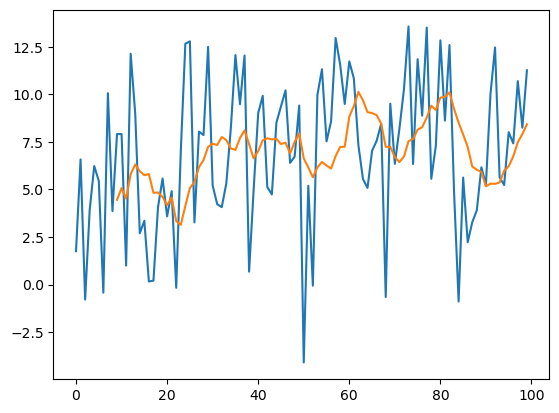

In [ ]:
avg_reward = np.array(reinforce.rewards).mean(1)
plt.figure() 
plt.plot(avg_reward)
plt.plot(pd.Series(avg_reward).rolling(window=10).mean())
plt.show()